# Ground Truth: Building and Augmenting Datasets
__Quantitative Big Imaging__ ETHZ: 227-0966-00L

<p style="font-size:1em;">March 11, 2021</p>
<br /><br />
<p style="font-size:1.5em;padding-bottom: 0.25em;">Anders Kaestner</p>  
<p style="font-size:1em;">Laboratory for Neutron Scattering and Imaging<br />Paul Scherrer Institut</p>

## Today's lecture

__Creating Datasets__
- Famous Datasets
- Types of Datasets
- What makes a good dataet?
- Building your own 
 - "scrape, mine, move, annotate, review, and preprocess" - Kathy Scott
 - tools to use
 - simulation

__Augmentation__
- How can you artifically increase the size of your dataset?
- What are the limits of these increases

__Baselines__
- What is a baseline?
- Example: Nearest Neighbor

## References

- Revisiting **Unreasonable Effectiveness of Data** in Deep Learning Era: https://arxiv.org/abs/1707.02968
- Building Datasets
    - Python Machine Learning 2nd Edition by Sebastian Raschka, Packt Publishing Ltd. 2017
     - Chapter 2: Building Good Datasets: https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch04/ch04.ipynb
    - A Standardised Approach for Preparing Imaging Data for Machine Learning Tasks in Radiology https://doi.org/10.1007/978-3-319-94878-2_6
- Creating Datasets / Crowdsourcing
 - Mindcontrol: A web application for brain segmentation quality control: https://www.sciencedirect.com/science/article/pii/S1053811917302707
 - Combining citizen science and deep learning to amplify expertise in neuroimaging: https://www.biorxiv.org/content/10.1101/363382v1.abstract
 
- Augmentation
 - https://github.com/aleju/imgaug
 - https://github.com/mdbloice/Augmentor

# Motivation
Most of you taking this class are rightfully excited to learn about new tools and algorithms to analyzing _your_ data. 

This lecture is a bit of an anomaly and perhaps disappointment because it doesn't cover any algorithms, or tools.
- So you might ask, why are we spending so much time on datasets?
- You already collected data (sometimes lots of it) that is why you took this class?!

... let's see what some other people say

### Sean Taylor (Research Scientist at Facebook)

```{figure} figures/data_tweet.jpg
---
scale: 50%
---
Realistic thoughts about AI.
```

<img src="figures/data_tweet.jpg" style="height:500px"/>

### Andrej Karpathy (Director of AI at Tesla)

```{figure} figures/karpathy_slide.jpg
---
scale: 70%
---
Time spent on different tasks.
```

<img src="figures/karpathy_slide.jpg" style="height:500px">

### Kathy Scott (Image Analytics Lead at Planet Labs)

```{figures} figures/kathy_tweet.png
---
scale: 70%
---
The importance to spend sufficient time on data preparation.
```

<img src="figures/kathy_tweet.png" style="height:700px">

## Data is important
It probably [isn't the _new_ oil](https://www.forbes.com/sites/bernardmarr/2018/03/05/heres-why-data-is-not-the-new-oil/), but it forms an essential component for building modern tools today.
- Testing good algorithms *requires* good data
 - If you don't know what to expect how do you know your algorithm worked?
 - If you have dozens of edge cases how can you make sure it works on each one?
 - If a new algorithm is developed every few hours, how can you be confident they actually work better (facebook's site has a new version multiple times per day and their app every other day)

- For machine learning, even building requires good data
 - If you count cells maybe you can write your own algorithm,
 - but if you are trying to detect subtle changes in cell structure that indicate cancer you probably can't write a list of simple mathematical rules yourself.


## Data is reusable

- Well organized and structured data is very easy to reuse. 
- Another project can easily combine your data with their data in order to get even better results.



- Algorithms are often messy, complicated, poorly written, ... (especially so if written by students trying to graduate on time)



<div class="alert alert-block alert-success">

<center>

## Data recycling saves time and improves performance

</center>

</div>

# Famous Datasets
The primary success of datasets has been shown through the most famous datasets collected. 

Here I show
- Two of the most famous general datasets 
    - MNIST Digits
    - ImageNET
- and one of the most famous medical datasets.
    - BRATS

The famous datasets are important for basic network training.

## [MNIST Digits](http://yann.lecun.com/exdb/mnist/)

Modified NIST (National Institute of Standards and Technology) created a list of handwritten digits
 
![Digits](figures/mnist.png)

## [ImageNet](http://www.image-net.org)
 - ImageNet is an image database 
     - organized according to the WordNet hierarchy (currently only the nouns), 
     - each node of the hierarchy is depicted by hundreds and thousands of images.
 - 1000 different categories and >1M images.
 - Not just dog/cat, but wolf vs german shepard, 

<table><tr><th>WordNet hierarchy</th><th>Classifier performance ImageNet</th></tr>
<tr><td><img src="figures/A-simplified-WordNet-hierarchy-of-synsets.png" style="height:300px"/></td>
    <td>
        <img src="figures/CNN-development.png" style="height:300px"/>
    
[CNN architectures](https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5)
   
</td></tr></table>




## [BRATS](http://braintumorsegmentation.org) 
Segmenting Tumors in Multimodal MRI Brain Images.

 <img src="figures/BRATS_tasks.png" style="height:600px">


## What story did these datasets tell?
Each of these datasets is very different from images with fewer than 1000 pixels to images with more than 100MPx, but what they have in common is how their analysis has changed.
### Hand-crafted features
All of these datasets used to be analyzed by domain experts with hand-crafted features. 
- A handwriting expert using graph topology to assign images to digits
- A computer vision expert using gradients common in faces to identify people in ImageNet
- A biomedical engineer using knowledge of different modalities to fuse them together and cluster healthy and tumorous tissue

### Machine Learning / Deep Learning
Starting in the early 2010s, the approaches of deep learning began to improve and become more computationally efficient. With these techniques groups with __absolutely no domain knowledge__ could begin building algorithms and winning contests based on these datasets

## So Deep Learning always wins? 
No, that isn't the point of this lecture. 

Even if you aren't using deep learning the point of these stories is having 
- well-labeled, 
- structured, 
- and organized datasets 

makes your problem *a lot more accessible* for other groups and enables a variety of different approaches to be tried. 

Ultimately it enables better solutions to be made and you to be confident that the solutions are in fact better

## Other Datasets
- Grand-Challenge.org a large number of challenges in the biomedical area
- [Kaggle Datasets](https://www.kaggle.com/datasets)
- [Google Dataset Search](https://datasetsearch.research.google.com/)


## What makes a good dataset?

### Lots of images
 - Small datasets can be useful but here the bigger the better
 - Particularly if you have 
     - Complicated problems
     - Very subtle differences (ie a lung tumor looks mostly like normal lung tissue but it is in a place it shouldn't be)
     - Class imbalance 
 

## What makes a good dataset?
### Lots of diversity
 - Is it what data 'in the wild' really looks like?
 - Lots of different 
     - Scanners/reconstruction algorithms, 
     - noise levels, 
     - illumination types, 
     - rotation, 
     - colors, ...
 - Many examples from different categories 
     - _if you only have one male with breast cancer it will be hard to generalize exactly what that looks like_
 

## What makes a good dataset?
### Meaningful labels
 - Clear task or question
 - Unambiguous (would multiple different labelers come to the same conclusion)
 - Able to be derived from the image alone 
    - _A label that someone cannot afford insurance is interesting but it would be nearly impossible to determine that from an X-ray of their lungs_
 - Quantiative!
 - Non-obvious 
     - _A label saying an image is bright is not a helpful label because you could look at the histogram and say that_

# Purpose of different types of Datasets
- Classification
- Regression
- Segmentation
- Detection
- Other

# Classification
- Taking an image and putting it into a category
- Each image should have exactly one category
- The categories should be non-ordered
- Example: 
 - Cat vs Dog
 - Cancer vs Healthy

# Classification example

Using TensorFlow backend.
/Users/kaestner/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kaestner/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kaestner/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kaestner/opt/anaconda3/lib/p

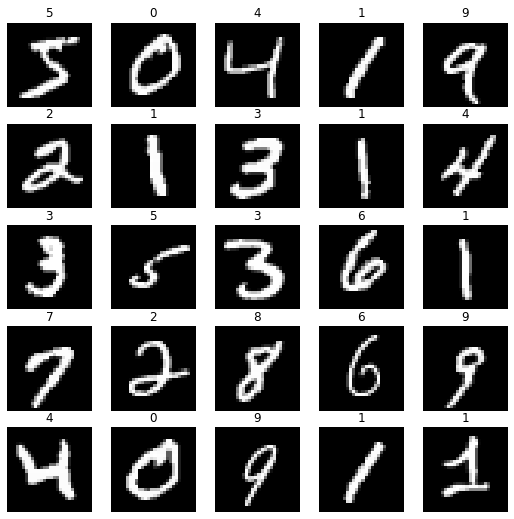

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from skimage.util import montage as montage2d
%matplotlib inline
(img, label), _ = mnist.load_data()
fig, m_axs = plt.subplots(5, 5, figsize=(9, 9))
for c_ax, c_img, c_label in zip(m_axs.flatten(), img, label):
    c_ax.imshow(c_img, cmap='gray')
    c_ax.set_title(c_label)
    c_ax.axis('off')

# Regression
- Taking an image and predicting one (or more) decimal values
- Examples: 
 - Value of a house from the picture taken by owner
 - Risk of hurricane from satellite image

# Regression example [Age from X-Rays](https://www.kaggle.com/kmader/rsna-bone-age) 
<center>
<img src="figures/bone_age.png" style="height=500px">
</center>

[More details](https://www.kaggle.com/kmader/attention-on-pretrained-vgg16-for-bone-age)

# Segmentation
- Taking an image and predicting one (or more) values for each pixel
- Every pixel needs a label (and a pixel cannot have multiple labels)
- Typically limited to a few (<20) different types of objects
- Examples:
 - Where a tumor is from an image of the lungs
 - Where streets are from satellite images of a neighborhood

# Segmentation example: Nuclei in Microscope Images

<table>
     <tr>
        <th>
            <center>Image</center>
        </th>
        <th>
            <center>Labelled</center>
        </th>
    </tr>
    <tr>
        <td>
            <img src="figures/dsb_sample/slide.png" style="height:600px">
        </td>
        <td>
            <img src="figures/dsb_sample/labels.png" style="height:600px">
        </td>
    </tr>
</table>

[More details on Kaggle](https://www.kaggle.com/c/data-science-bowl-2018)

# Detection
 - Taking an image and predicting where and which type of objects appear
 - Generally bounding box rather then specific pixels
 - Multiple objects can overlap

# Detection example: Opaque Regions in X-Rays

![Opacities](figures/lung_opacity.png)

[More details on Kaggle](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge)

# Other
 - Unlimited possibilities [here](https://junyanz.github.io/CycleGAN/)
 - Horses to Zebras 

## Image Enhancement 
  - Denoising [Learning to See in the Dark](http://cchen156.web.engr.illinois.edu/SID.html)
  - [Super-resolution](https://data.vision.ee.ethz.ch/cvl/DIV2K/)

# Building your own data sets

- Very time consuming
- Not a lot of great tools
- Very problem specific

## Code-free

### Classification
- Organize images into folders

### Regression
- Create an excel file (first column image name, next columns to regress)

### Segmentation / Object Detection
- Take [FIJI](http://fiji.sc/) and manually draw region to be identified and save it as a grayscale image

## Software for data labelling
### Free tools
 - Classification / Segmentation: https://github.com/Labelbox/Labelbox
 - Classification/ Object Detection: http://labelme.csail.mit.edu/Release3.0/
 - Classification: https://github.com/janfreyberg/superintendent: https://www.youtube.com/watch?v=fMg0mPYiEx0
 - Classification/ Detection: https://github.com/chestrays/jupyanno: https://www.youtube.com/watch?v=XDIJU5Beg_w
 - Classification (Tinder for Brain MRI): https://braindr.us/#/
 
### Commercial Approaches
 - https://www.figure-eight.com/
 - MightyAI / Spare5: https://mighty.ai/ https://app.spare5.com/fives/sign_in
 

## Simulations
Another way to enhance or expand your dataset is to use simulations
- already incorporate realistic data (game engines, 3D rendering, physics models)
- 100% accurate ground truth (original models)
- unlimited, risk-free playability (driving cars in the world is more dangerous)

#### Examples

- [P. Fuchs et al. - Generating Meaningful Synthetic Ground Truth for
Pore Detection in Cast Aluminum Parts, iCT 2019, Padova](https://pdfs.semanticscholar.org/30a1/ba9142b9c3b755da2bff7d93d704494fdaed.pdf)
- https://download.visinf.tu-darmstadt.de/data/from_games/
- https://pythonprogramming.net/self-driving-car-neural-network-training-data-python-plays-gta-v/
- https://towardsdatascience.com/learning-from-simulated-data-ff4be63ac89c



# Dataset Problems
Some of the issues which can come up with datasets are 
- imbalance
- too few examples
- too homogenous 
- and other possible problems

These lead to problems with the algorithms built on top of them. 

## Bias

![image.png](figures/google-racist-gorilla-doctored-tweet.png)

<div class="alert alert-block alert-warning">

### [The solution was to remove Gorilla from the category](https://www.theverge.com/2018/1/12/16882408/google-racist-gorillas-photo-recognition-algorithm-ai)

</div>


## Better solution would be to have training sets with more diverse people

<img src="figures/celeb_dataset.png" style="height:700px">

- [IBM Diverse Face Dataset](https://www.research.ibm.com/artificial-intelligence/trusted-ai/diversity-in-faces/)

# Example of image data and labels

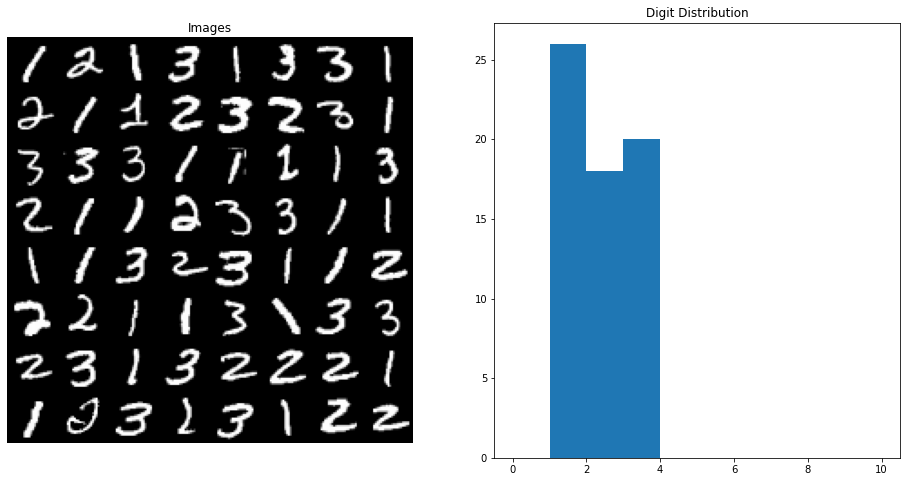

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from skimage.util import montage as montage2d
%matplotlib inline
(img, label), _ = mnist.load_data()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
d_subset = np.where(np.in1d(label, [1, 2, 3]))[0]
ax1.imshow(montage2d(img[d_subset[:64]]), cmap='gray')
ax1.set_title('Images')
ax1.axis('off')
ax2.hist(label[d_subset[:64]], np.arange(11))
ax2.set_title('Digit Distribution');

# Augmentation
- Most groups have too little well-labeled data and labeling new examples can be very expensive. 
- Additionally there might not be very many cases of specific classes. 
- In medicine this is particularly problematic, because some diseases might only happen a few times in a given hospital and you still want to be able to recognize the disease and not that particular person.

# Solutions to limited data
## Transformation
- Shift
- Zoom
- Rotation
- Intensity
 - Normalization
 - Scaling
- Color
- Shear

## Further modifications
- Add noise
- Blurring

## Some augmentation examples
<figure>
<img src="figures/Augmentations.svg" style="height:500px">
<figcaption>
    
Retial images from [DRIVE](https://drive.grand-challenge.org/DRIVE/) prepared by Gian Guido Parenza.
    
</figcaption>
</figure>

## Limitations of augmentation

- What transformations are normal in the images?
 - CT images usually do not get flipped (the head is always on the top)
 - The values in CT images have a physical meaning (Hounsfield unit), <br /> $\rightarrow$ scaling them changes the image
 
 
- How much distortion is too much? 
 - Can you still recognize the features?

## Manual for the ImageDataGenerator
```
ImageDataGenerator(
    ['featurewise_center=False', 'samplewise_center=False', 'featurewise_std_normalization=False', 'samplewise_std_normalization=False', 'zca_whitening=False', 'zca_epsilon=1e-06', 'rotation_range=0.0', 'width_shift_range=0.0', 'height_shift_range=0.0', 'shear_range=0.0', 'zoom_range=0.0', 'channel_shift_range=0.0', "fill_mode='nearest'", 'cval=0.0', 'horizontal_flip=False', 'vertical_flip=False', 'rescale=None', 'preprocessing_function=None', 'data_format=None'],
)
Docstring:     
Generate minibatches of image data with real-time data augmentation.

# Arguments
    featurewise_center: set input mean to 0 over the dataset.
    samplewise_center: set each sample mean to 0.
    featurewise_std_normalization: divide inputs by std of the dataset.
    samplewise_std_normalization: divide each input by its std.
    zca_whitening: apply ZCA whitening.
    zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
    rotation_range: degrees (0 to 180).
    width_shift_range: fraction of total width, if < 1, or pixels if >= 1.
    height_shift_range: fraction of total height, if < 1, or pixels if >= 1.
    shear_range: shear intensity (shear angle in degrees).
    zoom_range: amount of zoom. if scalar z, zoom will be randomly picked
        in the range [1-z, 1+z]. A sequence of two can be passed instead
        to select this range.
    channel_shift_range: shift range for each channel.
    fill_mode: points outside the boundaries are filled according to the
        given mode ('constant', 'nearest', 'reflect' or 'wrap'). Default
        is 'nearest'.
        Points outside the boundaries of the input are filled according to the given mode:
            'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
            'nearest':  aaaaaaaa|abcd|dddddddd
            'reflect':  abcddcba|abcd|dcbaabcd
            'wrap':  abcdabcd|abcd|abcdabcd
    cval: value used for points outside the boundaries when fill_mode is
        'constant'. Default is 0.
    horizontal_flip: whether to randomly flip images horizontally.
    vertical_flip: whether to randomly flip images vertically.
    rescale: rescaling factor. If None or 0, no rescaling is applied,
        otherwise we multiply the data by the value provided. This is
        applied after the `preprocessing_function` (if any provided)
        but before any other transformation.
    preprocessing_function: function that will be implied on each input.
        The function will run before any other modification on it.
        The function should take one argument:
        one image (Numpy tensor with rank 3),
```

In [5]:
from keras.preprocessing.image import ImageDataGenerator
img_aug = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=30.0,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.5,
    fill_mode='nearest',
    horizontal_flip=False,
    vertical_flip=False
)

## MNIST
Even something as simple as labeling digits can be very time consuming (maybe 1-2 per second).

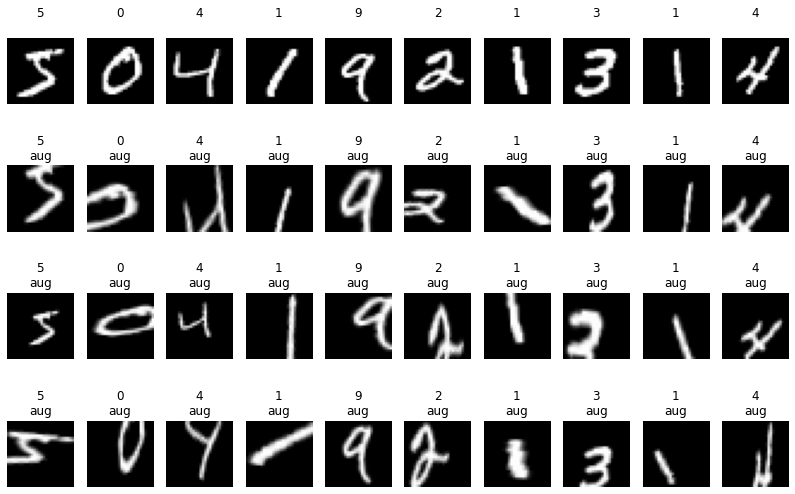

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
%matplotlib inline
(img, label), _ = mnist.load_data()
img = np.expand_dims(img, -1)
fig, m_axs = plt.subplots(4, 10, figsize=(14, 9))
# setup augmentation
img_aug.fit(img)
real_aug = img_aug.flow(img[:10], label[:10], shuffle=False)
for c_axs, do_augmentation in zip(m_axs, [False, True, True, True]):
    if do_augmentation:
        img_batch, label_batch = next(real_aug)
    else:
        img_batch, label_batch = img, label
    for c_ax, c_img, c_label in zip(c_axs, img_batch, label_batch):
        c_ax.imshow(c_img[:, :, 0], cmap='gray', vmin=0, vmax=255)
        c_ax.set_title('{}\n{}'.format( c_label, 'aug' if do_augmentation else ''))
        c_ax.axis('off')

# [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)
We can use a more exciting dataset to try some of the other features in augmentation

In [7]:
from keras.datasets import cifar10
(img, label), _ = cifar10.load_data()

In [8]:
img_aug = ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=30.0,
    width_shift_range=0.25,
    height_shift_range=0.25,
    channel_shift_range=0.25,
    shear_range=0.25,
    zoom_range=1,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True
)

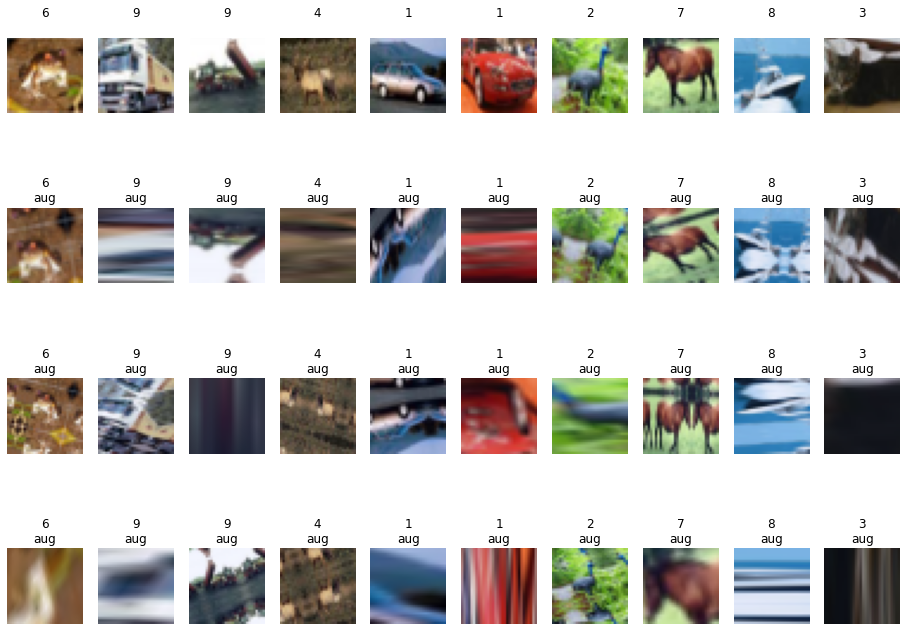

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
%matplotlib inline
fig, m_axs = plt.subplots(4, 10, figsize=(16, 12))
# setup augmentation
img_aug.fit(img)
real_aug = img_aug.flow(img[:10], label[:10], shuffle=False)
for c_axs, do_augmentation in zip(m_axs, [False, True, True, True]):
    if do_augmentation:
        img_batch, label_batch = next(real_aug)
        img_batch -= img_batch.min()
        img_batch = np.clip(img_batch/img_batch.max() *
                            255, 0, 255).astype('uint8')
    else:
        img_batch, label_batch = img, label
    for c_ax, c_img, c_label in zip(c_axs, img_batch, label_batch):
        c_ax.imshow(c_img)
        c_ax.set_title('{}\n{}'.format(
            c_label[0], 'aug' if do_augmentation else ''))
        c_ax.axis('off')

# Baselines
- A baseline is a simple, easily implemented and understood model that illustrates the problem and the 'worst-case scenario' for a model that learns nothing (some models will do worse, but these are especially useless).
- Why is this important?

## Baseline model example
I have a a model that is >99% accurate for predicting breast cancer

$$ \textrm{DoIHaveBreastCancer}(\textrm{Age}, \textrm{Weight}, \textrm{Race}) = \textrm{No!} $$

<div class="alert alert-box alert-danger">
Breast Cancer incidence is $\approx$ 89 of 100,000 women (0.09%) so always saying <b>no</b> has an accuracy of <b>99.91%</b>.
    </div>

## The dummy classifier

In [10]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier(strategy='most_frequent')
dc.fit([0, 1, 2, 3], 
       ['Healthy', 'Healthy', 'Healthy', 'Cancer'])

DummyClassifier(strategy='most_frequent')

In [11]:
dc.predict([0]), dc.predict([1]), dc.predict([3]), dc.predict([100])

(array(['Healthy'], dtype='<U7'),
 array(['Healthy'], dtype='<U7'),
 array(['Healthy'], dtype='<U7'),
 array(['Healthy'], dtype='<U7'))

## Try dummy classifier on MNIST data
First we load the data...

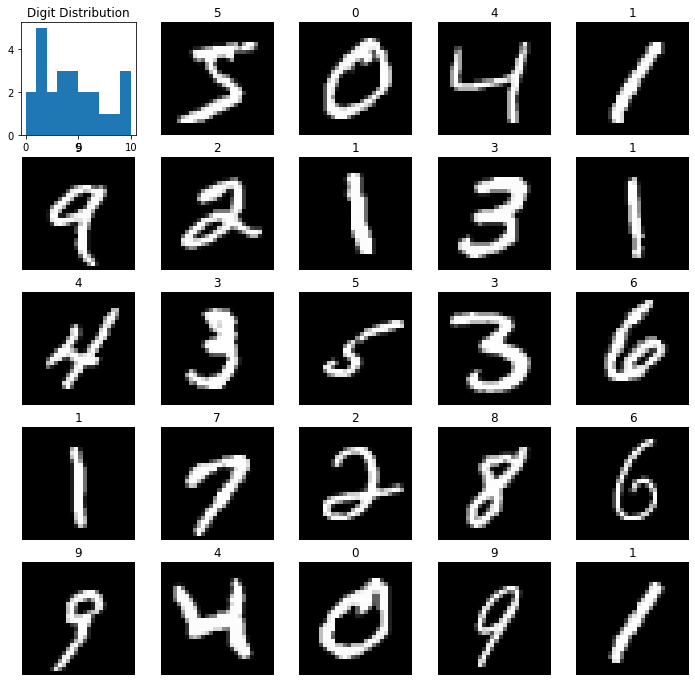

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from skimage.util import montage as montage2d
%matplotlib inline
(img, label), _ = mnist.load_data()
fig, m_axs = plt.subplots(5, 5, figsize=(12, 12))
m_axs[0, 0].hist(label[:24], np.arange(11))
m_axs[0, 0].set_title('Digit Distribution')
for i, c_ax in enumerate(m_axs.flatten()[1:]):
    c_ax.imshow(img[i], cmap='gray')
    c_ax.set_title(label[i])
    c_ax.axis('off')

# Let's train the model...

In [13]:
dc = DummyClassifier(strategy='most_frequent')
dc.fit(img[:24], label[:24])

DummyClassifier(strategy='most_frequent')

## A basic test

In [14]:
dc.predict(img[0:10])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

### ... why are all predictions = 1?

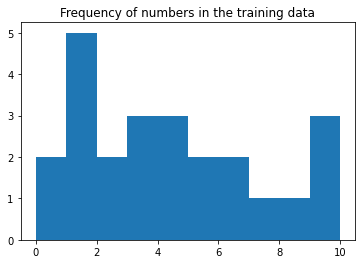

In [15]:
plt.hist(label[:24], np.arange(11)); plt.title('Frequency of numbers in the training data');

# Test on the images

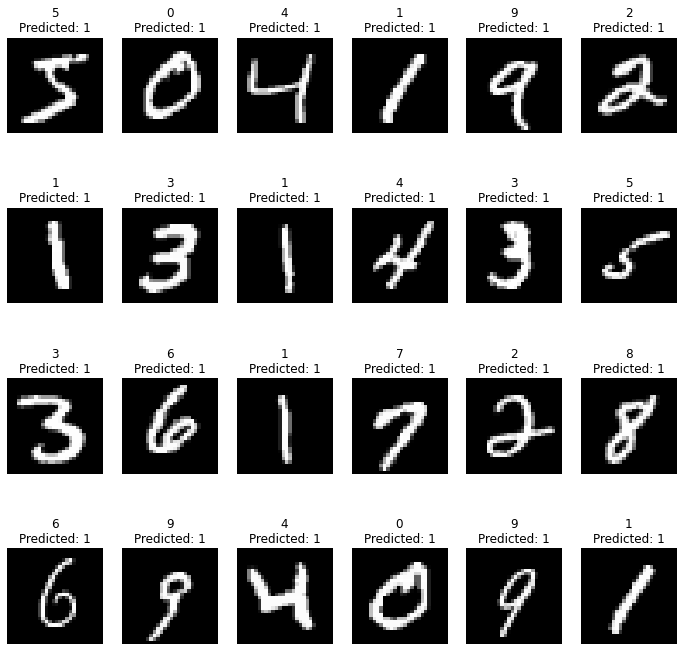

In [16]:
fig, m_axs = plt.subplots(4, 6, figsize=(12, 12))
for i, c_ax in enumerate(m_axs.flatten()):
    c_ax.imshow(img[i], cmap='gray')
    c_ax.set_title('{}\nPredicted: {}'.format(label[i], dc.predict(img[i])[0]))  
    c_ax.axis('off')

## Nearest Neighbor
This isn't a machine learning class and so we won't dive deeply into other methods, but nearest neighbor is often a very good baseline (that is also very easy to understand). You basically take the element from the original set that is closest to the image you show. 

<img src="figures/Russ_fig12_58.png" style="height:300px">

[Figure from J. Russ, Image Processing Handbook](https://www.crcpress.com/The-Image-Processing-Handbook/Russ-Neal/p/book/9781138747494)    

You can make the method more robust by using more than one nearest neighbor (hence K nearest neighbors), but that we will cover in the supervised methods lecture

# Let's load the data again...

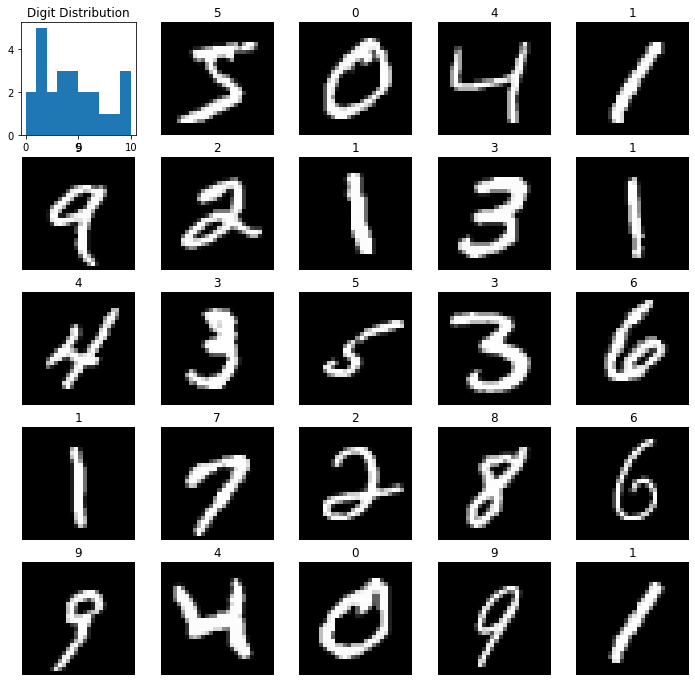

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from skimage.util import montage as montage2d
%matplotlib inline
(img, label), _ = mnist.load_data()
fig, m_axs = plt.subplots(5, 5, figsize=(12, 12))
m_axs[0, 0].hist(label[:24], np.arange(11))
m_axs[0, 0].set_title('Digit Distribution')
for i, c_ax in enumerate(m_axs.flatten()[1:]):
    c_ax.imshow(img[i], cmap='gray')
    c_ax.set_title(label[i])
    c_ax.axis('off')

In [18]:
from sklearn.neighbors import KNeighborsClassifier
neigh_class = KNeighborsClassifier(n_neighbors=1)
neigh_class.fit(img[:24].reshape((24, -1)), label[:24])

KNeighborsClassifier(n_neighbors=1)

In [19]:
# predict on a few images
neigh_class.predict(img[0:10].reshape((10, -1)))

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

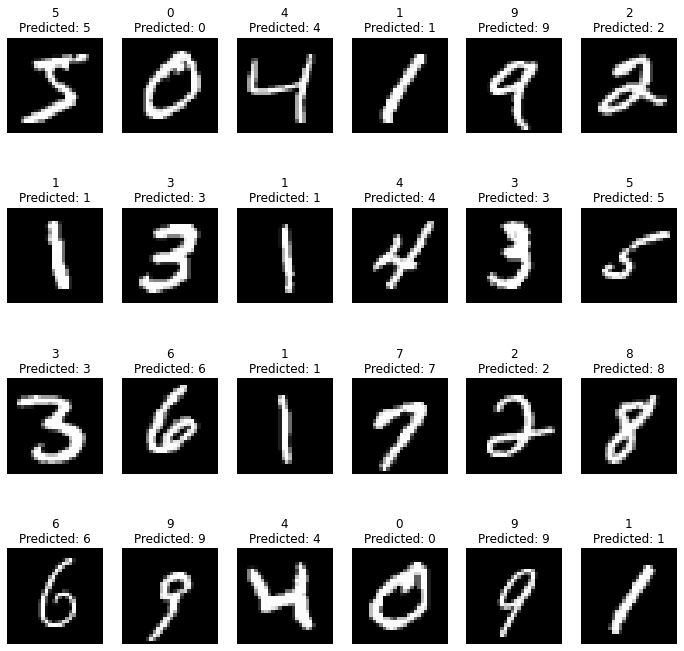

In [20]:
fig, m_axs = plt.subplots(4, 6, figsize=(12, 12))
for i, c_ax in enumerate(m_axs.flatten()):
    c_ax.imshow(img[i], cmap='gray')
    c_ax.set_title('{}\nPredicted: {}'.format(label[i], 
                                              neigh_class.predict(img[i].reshape((1, -1)))[0]))
    c_ax.axis('off')

## 100% for a baseline
Wow the model works really really well, it got every example perfectly. What we did here (a common mistake) was evaluate on the same data we 'trained' on which means the model just correctly recalled each example, if we try it on new images we can see the performance drop but still a reasonable result

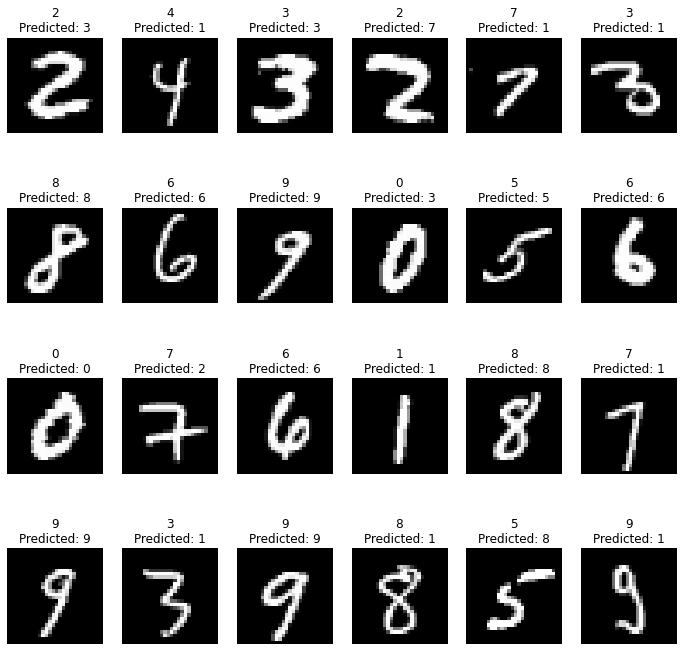

In [21]:
fig, m_axs = plt.subplots(4, 6, figsize=(12, 12))
for i, c_ax in enumerate(m_axs.flatten(), 25):
    c_ax.imshow(img[i], cmap='gray')
    c_ax.set_title('{}\nPredicted: {}'.format(label[i], 
                                              neigh_class.predict(img[i].reshape((1, -1)))[0]))
    c_ax.axis('off')

## How good is good?
We will cover more tools later in the class but now we will show the accuracy and the confusion matrix for our simple baseline model to evaluate how well it worked

### Confusion Matrix
We show which cases were most frequently confused 

<table>
    <tr><td>n=165</td><th>Predicted TRUE</th><th>Predicted FALSE</th></tr>
    <tr><th>Actual TRUE</th><td>50</td><td>10</td></tr>
    <tr><th>Actual FALSE</th><td>10</td><td>100</td></tr>
    </table>

In [22]:
import seaborn as sns
import pandas as pd
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Stolen from: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return ax1

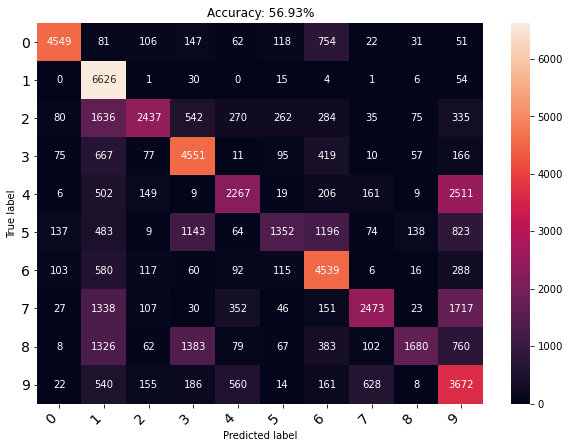

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix
pred_values = neigh_class.predict(img[24:].reshape((-1, 28*28)))
ax1 = print_confusion_matrix(confusion_matrix(label[24:], pred_values), class_names=range(10))
ax1.set_title('Accuracy: {:2.2%}'.format(accuracy_score(label[24:], pred_values)));

# Summary
